In [115]:
%load_ext autoreload
%autoreload 2

import lakeapi 
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import plotly.graph_objects as go 
import numpy as np
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import nolds
pd.set_option('display.max_rows', 100)
from helpers import calculate_rolling_ols_spread_fast
import itertools 

from pricing_signals import PricingSignal
from trading_strategy import BollingerBandTradeStrategy
from portfolio_manager.portfolio_manager import PortfolioManager
from portfolio_manager.baseline_trading_strategy import BuyHoldStrategy
from data_processing import summary_streaks_seconds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
resampled_df = pd.read_parquet('data/level1crypto_raw_origin_times_resampled.parquet')
TEST_CUTOFF = dt.datetime(2025, 9, 1)
train_df, test_df = resampled_df[resampled_df.index < TEST_CUTOFF], resampled_df[resampled_df.index >=TEST_CUTOFF]

# Question: Is an hourly updating OLS pairs trading strategy for ADA/SOL MORE or LESS profitable than an appropriate baseline benchmark strategy? 

- Need to take into account that there is another risk of overfitting/risk since we OPTIMISED and CHOSE the hourly lookback window BOTH on the training data

In [136]:
pairs_df = train_df[train_df['symbol'].isin(['ADA-USDT', 'SOL-USDT', 'BTC-USDT'])].pivot(
    columns='symbol', 
    values=['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size', 'mid_price']
).rename(columns={
    'bid_0_price': 'bid_price', 
    'ask_0_price': 'ask_price', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
}).swaplevel(axis=1)

CUTOFF_TRAINING = dt.datetime(2025, 1, 20)
CUTOFF_VALIDATION = dt.datetime(2025, 4, 1)
pairs_training_df = pairs_df[pairs_df.index<=CUTOFF_TRAINING]
# pairs_validation_df = pairs_df[pairs_df.index >=CUTOFF_VALIDATION].ffill()

In [137]:
SECONDS_PER_MINUTE = 60
pairs_training_df.swaplevel(axis=1)['mid_price'].apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,SOL-USDT,ADA-USDT
count,0.166667,214.666667,271.833333
mean,0.500000,0.583592,0.514102
std,NaN,14.693408,13.057055
min,0.500000,0.166667,0.166667
25%,0.500000,0.166667,0.166667
50%,0.500000,0.166667,0.166667
75%,0.500000,0.166667,0.166667
90%,0.500000,0.166667,0.333333
95%,0.500000,0.166667,0.333333
99%,0.500000,0.333333,0.500000


In [138]:
pairs_training_df.swaplevel(axis=1)['mid_price'].apply(lambda x: summary_streaks_seconds(x, stat = 'longest_location'))

symbol,BTC-USDT,SOL-USDT,ADA-USDT
0,2024-12-04 00:00:00,2024-12-05 00:00:00,2024-12-05 00:00:00
1,2024-12-04 00:00:20,2024-12-05 08:47:20,2024-12-05 08:47:20


In [118]:
pairs_training_df.isna().sum()

symbol             
BTC-USDT  bid_price        3
SOL-USDT  bid_price    20290
ADA-USDT  bid_price    21047
BTC-USDT  ask_price        3
SOL-USDT  ask_price    20290
ADA-USDT  ask_price    21047
BTC-USDT  bid_size         3
SOL-USDT  bid_size     20290
ADA-USDT  bid_size     21047
BTC-USDT  ask_size         3
SOL-USDT  ask_size     20290
ADA-USDT  ask_size     21047
BTC-USDT  mid_price        3
SOL-USDT  mid_price    20290
ADA-USDT  mid_price    21047
dtype: int64

In [65]:
pairs_training_df.head()
pairs_validation_df.head()

symbol,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT
,bid_price,bid_price,bid_price,ask_price,ask_price,ask_price,bid_size,bid_size,bid_size,ask_size,ask_size,ask_size,mid_price,mid_price,mid_price
origin_time,,,,,,,,,,,,,,,
2024-11-26 00:00:00,92935.90,233.87,0.9426,92935.91,233.88,0.9427,2.55032,50.141,4115.9,0.36348,74.033,3701.5,92935.905,233.875,0.94265
2024-11-26 00:00:10,93154.46,234.33,0.9426,93154.47,234.34,0.9427,1.00850,0.023,4115.9,1.57237,66.220,3701.5,93154.465,234.335,0.94265
2024-11-26 00:00:20,93034.63,234.21,0.9434,93034.64,234.22,0.9435,0.00271,102.100,4616.5,3.10595,22.076,10869.4,93034.635,234.215,0.94345
2024-11-26 00:00:30,93071.42,234.14,0.9440,93071.43,234.15,0.9441,1.34965,51.115,1610.6,0.00041,44.458,4015.1,93071.425,234.145,0.94405
2024-11-26 00:00:40,93028.00,234.14,0.9440,93028.75,234.15,0.9441,0.00540,51.115,1610.6,0.00265,44.458,4015.1,93028.375,234.145,0.94405


symbol,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT,BTC-USDT,SOL-USDT,ADA-USDT
,bid_price,bid_price,bid_price,ask_price,ask_price,ask_price,bid_size,bid_size,bid_size,ask_size,ask_size,ask_size,mid_price,mid_price,mid_price
origin_time,,,,,,,,,,,,,,,
2025-04-05 00:00:00,83880.00,122.84,0.6610,83880.01,122.85,0.6611,1.44672,130.413,18128.1,3.54216,60.481,2016.0,83880.005,122.845,0.66105
2025-04-05 00:00:10,83851.52,122.80,0.6609,83851.53,122.81,0.6610,0.26102,285.292,12576.8,6.20186,27.144,17398.3,83851.525,122.805,0.66095
2025-04-05 00:00:20,83846.00,122.78,0.6610,83846.01,122.79,0.6611,0.19109,891.873,23835.9,5.68773,462.844,29589.2,83846.005,122.785,0.66105
2025-04-05 00:00:30,83836.50,122.79,0.6611,83836.51,122.80,0.6612,0.00352,383.611,16065.6,5.14921,40.706,13574.4,83836.505,122.795,0.66115
2025-04-05 00:00:40,83830.18,122.76,0.6604,83830.19,122.77,0.6605,3.84064,55.051,12866.8,3.04023,414.031,13787.0,83830.185,122.765,0.66045


In [66]:
#Variables 
DAYS_IN_WEEK = 7 
HOURS_IN_DAYS = 24
MINUTES_PER_HOUR = 60 
TICKS_PER_MINUTE = 6

BETA_LOOKBACK_BY_FREQUENCY = {
    'hour': 1*MINUTES_PER_HOUR*TICKS_PER_MINUTE,
    'day': 1*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, # 1 day, 
    'week': 7*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE,  # 7 days, 
    'month': 30*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 days (1 month)
}

MA_UNITS_BY_FREQUENCY = {
    'hour': 30*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 minutes 
    'day': 12*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE
}

TRADING_PERIODS_PER_YEAR = TICKS_PER_MINUTE*MINUTES_PER_HOUR*HOURS_IN_DAYS*365

In [50]:
#Part 1: Find the optimal trading strategy parameters based on hourly signal data 

#Note there is no need to use k-fold cross-validation since the entry, exit and MA lookback are really PARAMETERs of the model and so they shoul be trained on the dataset 
entry_threshold = [1, 2]
exit_threshold = [0.25, 0.5]
lookback_multiple = [0.25, 0.5, 2]
grid_search = list(itertools.product(entry_threshold, exit_threshold, lookback_multiple))
hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour']

results_by_param = {}
temp_df = pairs_training_df.head(n=100_000)

for (entry, exit, lookback_multiple) in grid_search: 
    #Generate signal on rolling OLS with hourly frequency, but with a different SPREAD lookback 
    signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
    #use midprices to generate signal 
    signal_results = signal._generate(y = temp_df['ADA-USDT']['mid_price'], x = temp_df['SOL-USDT']['mid_price'])
    #initialise an entry 
    results_by_param[(entry, exit, lookback_multiple)] = {'signal': signal_results}
    #desired positions 
    bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
    desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta = signal_results['beta'])
    results_by_param[(entry, exit, lookback_multiple)]['desired_positions'] = desired_positions 
    #portfolio manager 
    pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
    backtest_results = pm.backtest(close_positions = desired_positions, prices_y = temp_df['ADA-USDT'][['bid_price', 'ask_price']], prices_x = temp_df['SOL-USDT'][['bid_price', 'ask_price']])
    results_by_param[(entry, exit, lookback_multiple)]['backtest'] = backtest_results

100%|██████████| 100000/100000 [00:09<00:00, 11072.16it/s]


In [51]:
sharpe_ratios = {k: results_by_param[k]['backtest']['sharpe'] for k in results_by_param.keys()}
max(sharpe_ratios, key = sharpe_ratios.get)
sharpe_ratios

(2, 0.5, 0.25)

{(1, 0.25, 0.25): np.float64(-5.958838765979529),
 (1, 0.25, 0.5): np.float64(-5.669354915708657),
 (1, 0.25, 2): np.float64(-4.770865203215347),
 (1, 0.5, 0.25): np.float64(-4.316541437938481),
 (1, 0.5, 0.5): np.float64(-4.6317122473818175),
 (1, 0.5, 2): np.float64(-3.9479913184852027),
 (2, 0.25, 0.25): np.float64(4.092411886122292),
 (2, 0.25, 0.5): np.float64(4.408421309676578),
 (2, 0.25, 2): np.float64(0.37977007146626673),
 (2, 0.5, 0.25): np.float64(5.39115082820005),
 (2, 0.5, 0.5): np.float64(4.561462995261951),
 (2, 0.5, 2): np.float64(1.7672302477017447)}

In [52]:
sharpe_ratios[(2, 0.5, 0.25)]

np.float64(5.39115082820005)

# In-sample validation 

Try to find the best possible VERSION of this trading strategy as you can. 

In [86]:
#Part 1: Find the optimal trading strategy parameters based on hourly signal data 

#Note there is no need to use k-fold cross-validation since the entry, exit and MA lookback are really PARAMETERs of the model and so they shoul be trained on the dataset 
entry_threshold = [0.5, 1, 2]
exit_threshold = [0.25, 0.5, 1]
lookback_multiple = [0.25, 0.5, 1, 2]
grid_search = list(itertools.product(entry_threshold, exit_threshold, lookback_multiple))
hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour']

results_by_param = {}
temp_df = pairs_training_df

for (entry, exit, lookback_multiple) in grid_search:
    if exit >= entry: 
        continue 
    #Generate signal on rolling OLS with hourly frequency, but with a different SPREAD lookback 
    signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
    #use midprices to generate signal 
    signal_results = signal._generate(y = temp_df['ADA-USDT']['mid_price'], x = temp_df['SOL-USDT']['mid_price'])
    #initialise an entry 
    results_by_param[(entry, exit, lookback_multiple)] = {'signal': signal_results}
    #desired positions 
    bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
    desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta = signal_results['beta'])
    results_by_param[(entry, exit, lookback_multiple)]['desired_positions'] = desired_positions 
    #portfolio manager 
    pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
    backtest_results = pm.backtest(close_positions = desired_positions, prices_y = temp_df['ADA-USDT'][['bid_price', 'ask_price']], prices_x = temp_df['SOL-USDT'][['bid_price', 'ask_price']])
    results_by_param[(entry, exit, lookback_multiple)]['backtest'] = backtest_results

100%|██████████| 1105921/1105921 [01:50<00:00, 9973.32it/s] 


In [87]:
results_by_param.keys()

dict_keys([(0.5, 0.25, 0.25), (0.5, 0.25, 0.5), (0.5, 0.25, 1), (0.5, 0.25, 2), (1, 0.25, 0.25), (1, 0.25, 0.5), (1, 0.25, 1), (1, 0.25, 2), (1, 0.5, 0.25), (1, 0.5, 0.5), (1, 0.5, 1), (1, 0.5, 2), (2, 0.25, 0.25), (2, 0.25, 0.5), (2, 0.25, 1), (2, 0.25, 2), (2, 0.5, 0.25), (2, 0.5, 0.5), (2, 0.5, 1), (2, 0.5, 2), (2, 1, 0.25), (2, 1, 0.5), (2, 1, 1), (2, 1, 2)])

In [88]:
sharpe_ratios = {k: results_by_param[k]['backtest']['sharpe'] for k in results_by_param.keys()}
max(sharpe_ratios, key = sharpe_ratios.get)
sharpe_ratios

(2, 0.5, 0.5)

{(0.5, 0.25, 0.25): np.float64(-2.819348704500937),
 (0.5, 0.25, 0.5): np.float64(-2.2812060379243984),
 (0.5, 0.25, 1): np.float64(-1.1667206555383527),
 (0.5, 0.25, 2): np.float64(-1.1887217606752736),
 (1, 0.25, 0.25): np.float64(0.7605735577082199),
 (1, 0.25, 0.5): np.float64(1.2132316199048514),
 (1, 0.25, 1): np.float64(1.013586701339177),
 (1, 0.25, 2): np.float64(1.1447330062717178),
 (1, 0.5, 0.25): np.float64(0.14313249277679083),
 (1, 0.5, 0.5): np.float64(0.9973334091991879),
 (1, 0.5, 1): np.float64(0.8171626219566356),
 (1, 0.5, 2): np.float64(1.0112151113751129),
 (2, 0.25, 0.25): np.float64(3.36038264668422),
 (2, 0.25, 0.5): np.float64(3.626843993999807),
 (2, 0.25, 1): np.float64(3.7330435589514535),
 (2, 0.25, 2): np.float64(2.781915340304151),
 (2, 0.5, 0.25): np.float64(3.5326012925426578),
 (2, 0.5, 0.5): np.float64(4.342530956512978),
 (2, 0.5, 1): np.float64(3.8588303197781486),
 (2, 0.5, 2): np.float64(3.6290904045745354),
 (2, 1, 0.25): np.float64(3.418571281

In [90]:
winning_results = results_by_param[(2, 0.5, 0.5)]

<Axes: xlabel='origin_time'>

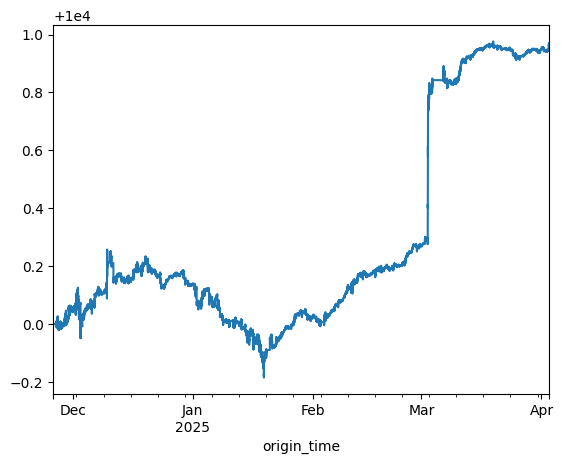

In [92]:
winning_results['backtest']['equity_curve'].plot()

<Axes: xlabel='origin_time'>

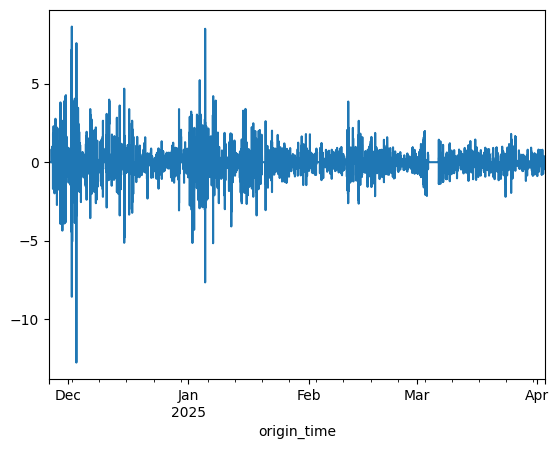

In [96]:
winning_results['backtest']['position_value'].plot()

In [93]:
winning_results['backtest']['sharpe']

np.float64(4.342530956512978)

Main questions: 
- Is it excellent? 
  - Not sure since I have literally no sense of scale and a lot of trading strategy execution dynamics are not yet impelemented- do we need a benchmark strategy here as a kind of "baseline"? OR we can just look up historical ones --> probably easier.

- Is it overfit? 
  - Most likely - concern about the sudden spike in equity curve - why? Need to investigate. Since otherwise it kind of looks like pretty damn lacklustre 

In [ ]:
# Question 1 - Why sudden spike in profits? Seems a bit unrealistic. 

# Note this is most likely due to problem of missing data, so we exclude and then see if this affects our training. 

In [ ]:
# Data errors? Didn't we already fucking clean this already?? 
cutoff_df = pairs_df[pairs_df.index<=CUTOFF_TRAINING]

In [109]:
pairs_df = train_df[train_df['symbol'].isin(['ADA-USDT', 'SOL-USDT', 'BTC-USDT'])].pivot(
    columns='symbol', 
    values=['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size', 'mid_price']
).rename(columns={
    'bid_0_price': 'bid_price', 
    'ask_0_price': 'ask_price', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
})

array([<Axes: xlabel='origin_time'>, <Axes: xlabel='origin_time'>,
       <Axes: xlabel='origin_time'>], dtype=object)

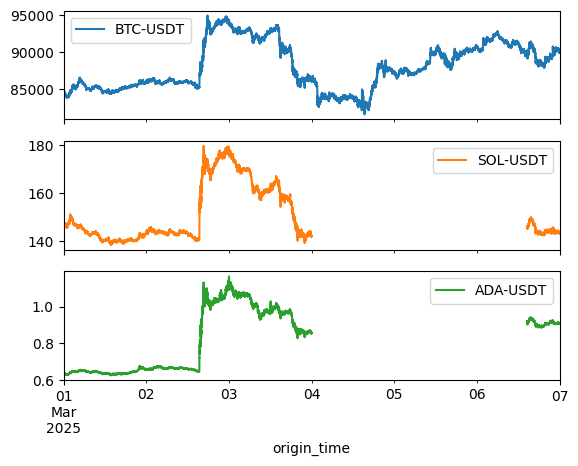

In [114]:
pairs_df['mid_price'].loc[dt.date(2025, 3, 1): dt.date(2025, 3, 7)].plot(subplots=True)

#